In [1]:
# Add module path for demo.
# Todo: make wheel file -> setup file -> pip install tsx-**.whl
import os
import sys
import pyts
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch

from tsx.perturbation import TimeSeriesPerturbation
from tsx.xai.lime import LIMETimeSeries

from data_util import *
from viz import *


## Prepare Data Set and Model

In [3]:
independents = ["dew", "temp", "press", "wind_direction", "wind_speed", "snow", "rain"]
dependent = "pollution"

df = load_data_set_bejin()
x_scaler, y_scaler = get_xy_scalers(df, independents, dependent)

# Global param
n_steps = 128
window_size = 8
n_variables = len(independents)

In [4]:
# Prepare predict function
wavenet = tf.keras.models.load_model(f"{DATA_DIR}/wavenet_mts_128_1.h5")
lstm = tf.keras.models.load_model(f"{DATA_DIR}/lstm_mts_128_1.h5")

def predict_fn(z, model=lstm):
    z_reshaped = z.T.reshape(1, 128, 7)
    z_hat = model.predict(z_reshaped)
    # to avoid zero coef_ for z_hat in[0, 1]
    z_hat = y_scaler.inverse_transform(z_hat.reshape(-1, 1))  
    z_hat = z_hat.ravel()   # z_hat will arround 50 - 150
    return z_hat[0]

array([<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>], dtype=object)

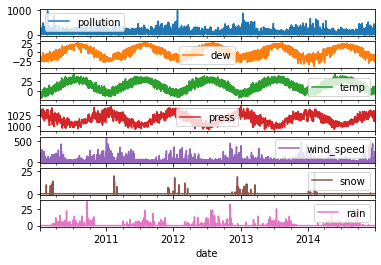

In [5]:
# Visualize the dataset 
df.loc[:, df.columns != 'wind_direction'].plot(subplots=True)

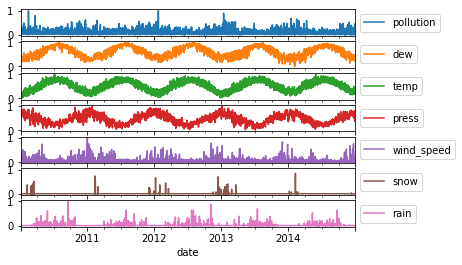

In [6]:
# Normalize data 
df_norm = df.copy()
df_norm[independents] = x_scaler.transform(df[independents].values)
df_norm[dependent] = y_scaler.transform(df[dependent].values.reshape(-1, 1))
_df = df_norm.loc[:, df_norm.columns != 'wind_direction']
plt_x_instance(_df)

### Select randomly an instance of X from test-set

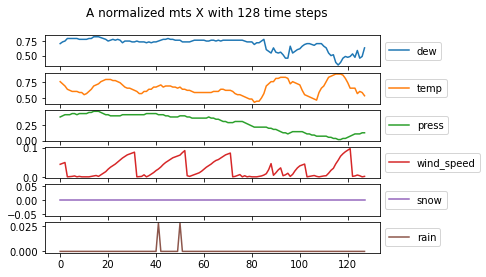

In [7]:
# Normalize data 
x = get_instance_x(df_norm, n_steps, independents)
x_mts = x.loc[:, x.columns != 'wind_direction']
title = f"A normalized mts X with {n_steps} time steps"

plt_x_instance(x_mts, title)

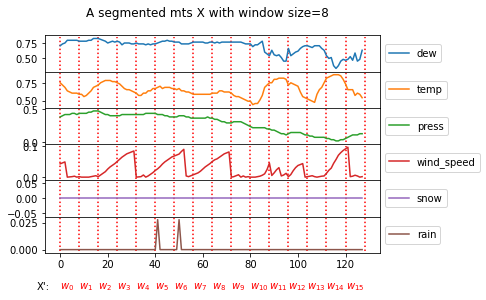

In [8]:
# X-segmented
title = f"A segmented mts X with window size={window_size}"
plt_x_segmented(x_mts, window_size, title)

### Predict Function or explaining models

In [9]:
# Perturbation Async
samples_size = 100
ts_x = x.values.T # (n_features, n_steps) 
ts_lime = LIMETimeSeries(scale="async", window_size=window_size, sample_size=samples_size)
ts_lime = ts_lime.explain(ts_x, predict_fn=predict_fn)

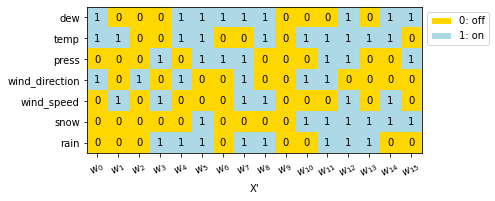

In [10]:
# Visualization Perturbation - Async and z_prime
z_prime, z, _, _ = ts_lime.get_a_local_sample()
plt_sample_z_prime(z_prime, ylabels=independents)

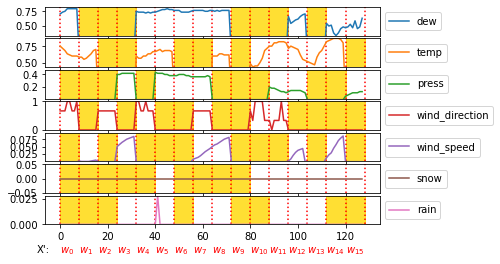

In [11]:
# z_df = x.copy()
# z_df[independents] = z.T    # -> df shape (n_steps, n_features)

plt_sample_z(x, z, z_prime, independents, window_size)

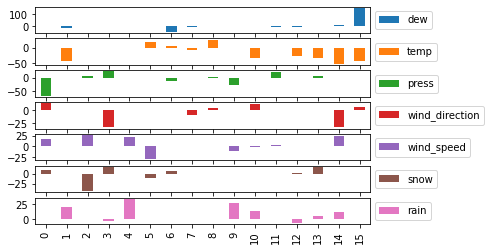

In [12]:
# Plot XAI Weight
plt_coef(ts_x, ts_lime.coef, feature_names=independents, legend=False, title=False)

### Multiple run and average

In [13]:
instances = []
n_instances = 10
for i in range(n_instances):
    _x_df = get_instance_x(df_norm, n_steps, independents)
    # _x_df[:] = x_scaler.transform(_x_df.values)
    instances.append(_x_df.values.T)

In [14]:
ts_lime = LIMETimeSeries(window_size=8, sample_size=100)
ts_lime.explain_instances(instances, predict_fn=predict_fn)

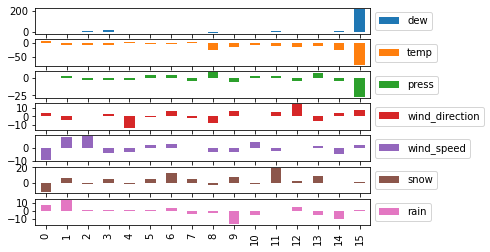

In [15]:
plt_coef(ts_x, ts_lime.coef, feature_names=independents, legend=False, title=False)